## **Análise de Sentimento em Reviews da Amazon usando NLP**

#### **Objetivo:**

O objetivo deste projeto é realizar a análise de sentimentos em reviews fornecidos pelos usuários da Amazon utilizando a técnica de Processamento de Linguagem Natural (NLP). A meta principal é desenvolver um modelo capaz de inferir se um review é positivo ou negativo. Para isso, serão aplicadas técnicas de pré-processamento de texto, dividindo os dados em conjuntos de treino e teste, e treinando um modelo de Regressão Logística.

**Instalação do módulo e importação das bibliotecas**

In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import string 
from nltk.corpus import stopwords ## nltk stopwords
from sklearn.model_selection import train_test_split ## train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer ## CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB ## MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve ## classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE ## Smote
from imblearn.pipeline import Pipeline ## imblearn pipeline
import matplotlib.pyplot as plt ## matplotlib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt

**Carregamento do dataset e análise exploratória**

In [4]:
df = pd.read_csv("amazon_sentiment_analysis.csv") # carregando o dataset
df.head()

,review,sentiment
0,Expensive Junk: This product consists of a pie...,bad
1,"Toast too dark: Even on the lowest setting, th...",bad
2,Excellent imagery...dumbed down story: I enjoy...,good
3,Are we pretending everyone is married?: The au...,bad
4,Not worth your time: Might as well just use a ...,bad


In [5]:
df = pd.DataFrame(data=df) # transformando o dataset em DataFrame
df.head()

,review,sentiment
0,Expensive Junk: This product consists of a pie...,bad
1,"Toast too dark: Even on the lowest setting, th...",bad
2,Excellent imagery...dumbed down story: I enjoy...,good
3,Are we pretending everyone is married?: The au...,bad
4,Not worth your time: Might as well just use a ...,bad


In [7]:
# Não há valores faltantes no DataFrame. Ambas as colunas, "review" e "sentiment", têm 559500 entradas não nulas, indicando que não há valores ausentes em nenhuma das colunas.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559500 entries, 0 to 559499
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     559500 non-null  object
 1   sentiment  559500 non-null  object
dtypes: object(2)
memory usage: 8.5+ MB


In [8]:
df['sentiment'].value_counts().unique # Existe mais avaliações boas do que ruins, mas a diferença é pouca

<bound method Series.unique of good    279786
bad     279714
Name: sentiment, dtype: int64>

**Transformação dos Valores Target** 

 Ao lidar com problemas de classificação, é comum que as variáveis-alvo estejam representadas de maneira categórica, muitas vezes utilizando rótulos textuais. No entanto, a maioria dos modelos de machine learning exige que esses rótulos sejam numéricos para funcionar corretamente. Portanto, a etapa de transformação dos valores-alvo é crucial para garantir a compatibilidade com o algoritmo escolhido.


In [9]:
# Criando função para transformar os valores target em numéricos (bad = 1 e good = 0)
def sentimento (row):
  if row ["sentiment"] == 'good':
    return 0
  else:
    return 1
df['sentiment2'] =df.apply(sentimento, axis=1)

In [11]:
df

,review,sentiment,sentiment2
0,Expensive Junk: This product consists of a pie...,bad,1
1,"Toast too dark: Even on the lowest setting, th...",bad,1
2,Excellent imagery...dumbed down story: I enjoy...,good,0
3,Are we pretending everyone is married?: The au...,bad,1
4,Not worth your time: Might as well just use a ...,bad,1
...,...,...,...
559495,"PS: Correction (sorry, wasn't able to edit my ...",good,0
559496,awesome cloth blocks: These blocks are perfect...,good,0
559497,EXCELLENT PRINCE: This recording is pure Princ...,good,0
559498,"LOVE IT, LOVE IT, LOVE IT!: Here's the scene: ...",good,0


**Distribuição das Variáveis Resposta**


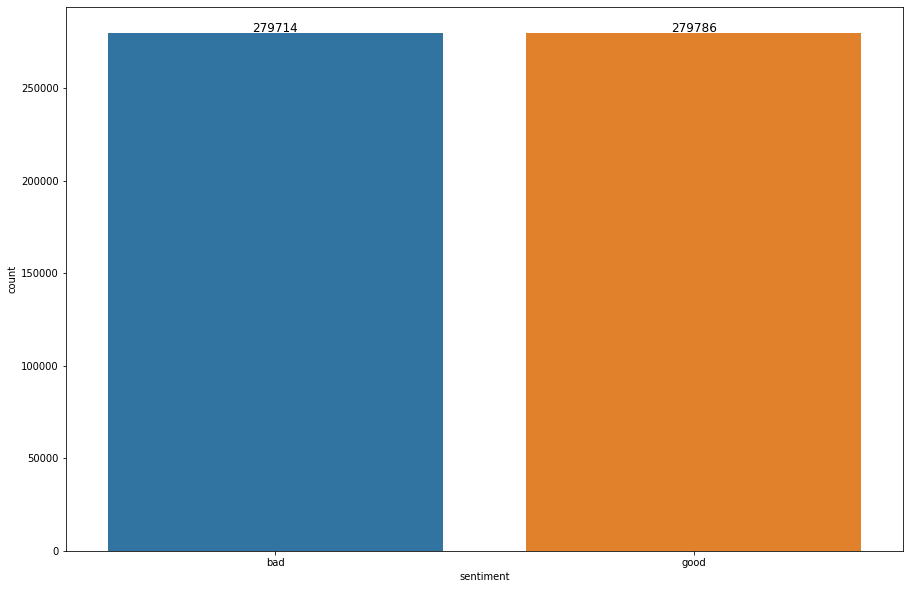

In [13]:
# Criando gráfico para verificar a distribuição das variáveis resposta (good e bad)
fig = plt.figure(figsize=(15, 10))
ax = sns.countplot(x='sentiment', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


**Pré-processamento do Texto**


Na etapa de pré-processamento do texto, buscamos criar uma representação mais adequada para a análise de sentimentos. Utilizamos expressões regulares, como \w e \S, para identificar e manter apenas os caracteres relevantes em uma string. O \w procura por caracteres de palavras, abrangendo letras de az, AZ, e dígitos de 0 a 9. Já o \S identifica qualquer caractere que não seja um espaço em branco.

In [14]:
df['review'] = df['review'].str.replace('[^\W\S]','')

C:\Users\leoar\AppData\Local\Temp\ipykernel_24696\1959112686.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^\W\S]','')


Download das stopwords

As stopwords são palavras comuns removidas durante o pré-processamento de texto, pois não oferecem contribuição significativa para a análise de sentimentos ou outras tarefas de processamento de linguagem natural. Essa ação ajuda a reduzir a dimensionalidade dos dados e destaca palavras mais relevantes para a tarefa em questão.

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leoar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Método utilizado para: 


Remoção de Pontuação: Utiliza uma lista de compreensão para criar uma nova lista chamada nopunc, contendo apenas os caracteres que não são pontuações. Isso é feito verificando se cada caractere na string de texto não está na string de pontuações fornecida pela biblioteca string.

Junção dos Caracteres: Usa o método join para unir os caracteres da lista nopunc e formar novamente uma string, eliminando assim a pontuação.

Remoção de Stopwords: Cria uma lista contendo apenas as palavras que não são stopwords. Usa a lista de stopwords da língua inglesa fornecida pela biblioteca NLTK para realizar essa remoção.

Retorno: Retorna a linha 1 resultante para verificação após a remoção de pontuações e stopwords.

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

text_process(df['review'].iloc[1])


['Toast',
 'dark',
 'Even',
 'lowest',
 'setting',
 'toast',
 'dark',
 'liking',
 'Also',
 'light',
 'stays',
 'lit',
 'unplug',
 'avoid',
 'wasting',
 'electricity',
 'quality',
 'expected',
 'Cuisinart']

In [21]:
df

,review,sentiment,sentiment2
0,Expensive Junk: This product consists of a pie...,bad,1
1,"Toast too dark: Even on the lowest setting, th...",bad,1
2,Excellent imagery...dumbed down story: I enjoy...,good,0
3,Are we pretending everyone is married?: The au...,bad,1
4,Not worth your time: Might as well just use a ...,bad,1
...,...,...,...
559495,"PS: Correction (sorry, wasn't able to edit my ...",good,0
559496,awesome cloth blocks: These blocks are perfect...,good,0
559497,EXCELLENT PRINCE: This recording is pure Princ...,good,0
559498,"LOVE IT, LOVE IT, LOVE IT!: Here's the scene: ...",good,0


**Preparação dos Dados**

A preparação dos dados é uma etapa crucial antes do treinamento de modelos de machine learning. Nesta seção, as variáveis são definidas para alimentar o modelo de análise de sentimentos.


A variável X representa as características (no caso, as reviews), enquanto y é a variável resposta que indica se o sentimento é positivo ou negativo. 

In [22]:
X = df['review'] # features
y = df['sentiment2'] # variável resposta
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) #dividindo em conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((391650,), (167850,), (391650,), (167850,))

Nesta etapa, optamos por utilizar um modelo de Regressão Logística para classificação, uma escolha comum para problemas binários como o de determinar se um review é positivo ou negativo.

 A Regressão Logística utiliza a função logística para modelar a relação entre as variáveis independentes e a probabilidade de uma instância pertencer a uma classe específica. A função logística transforma valores em uma escala de 0 a 1, representando probabilidades.

In [23]:
# Instanciando o modelo de regressão logistica para classificação
lr_clf = LogisticRegression(max_iter=3000)

**Treinamento do modelo**

O uso do pipeline facilita a aplicação consistente dessas transformações e o treinamento do modelo. Esse processo é essencial para que o modelo possa aprender a relação entre as características das reviews e seus sentimentos associados.

Ao treinar o modelo, os dados passam por cada uma dessas etapas, resultando em um fluxo de processamento eficiente e organizado.


In [24]:
# Construindo o pipeline com etapas de processamento de texto e classificação
model = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Converte strings em contagens de tokens
    ('tfidf', TfidfTransformer()),  # Converte contagens de tokens em pontuações TF-IDF ponderadas
    ('classifier', lr_clf),  # Regressão Logística
])

In [25]:
model.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001A45DF709D0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression(max_iter=3000))])

In [26]:
y_pred =  model.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     83881
           1       0.90      0.89      0.89     83969

    accuracy                           0.89    167850
   macro avg       0.89      0.89      0.89    167850
weighted avg       0.89      0.89      0.89    167850

